<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/auto_quantum_circuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Quantum Circuits
#### dehls - pinballsurgeon@gmail.com

In [99]:
!pip install --quiet tensorflow_quantum

In [100]:
import cirq
import sympy
import tensorflow
import numpy
import gc

%matplotlib inline
from matplotlib import pyplot

from cirq.contrib.svg import SVGCircuit

import tensorflow_quantum

Helper Functions

In [101]:
# given a data and out qubit structure, build dynamic circuit
class circuit_struct():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [102]:
# given a combination of qubit grid size and gate population, build 
def create_quantum_model(gridSize, hyperGates):

    # cirq
    data_qubits = cirq.GridQubit.rect(gridSize, gridSize)
    readout = cirq.GridQubit(-1, -1)         
    circuit = cirq.Circuit()
    
    # prepare the readout qubit
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    # create qubit
    builder = circuit_struct(
        data_qubits = data_qubits,
        readout=readout)

    # buid layers
    for gate in hyperGates:

      # builder.add_layer(circuit, cirq.XX, "xx1")
      builder.add_layer(circuit, gate, "zz1")
   
    # prepare the readout qubit
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [103]:
### pixel to qubit
def convert_to_circuit(image):

    values = numpy.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

In [104]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., numpy.newaxis]/255.0, x_test[..., numpy.newaxis]/255.0

In [105]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [106]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [107]:
x_train_small = tensorflow.image.resize(x_train, (4,4)).numpy()
x_test_small = tensorflow.image.resize(x_test, (4,4)).numpy()

In [108]:
x_train_nocon, y_train_nocon = x_train_small[:100], y_train[:100]

In [109]:
x_train_circ = [convert_to_circuit(x) for x in x_train_nocon]
x_test_circ = [convert_to_circuit(x) for x in x_test_small]

In [110]:
x_train_tfcirc = tensorflow_quantum.convert_to_tensor(x_train_circ)
x_test_tfcirc = tensorflow_quantum.convert_to_tensor(x_test_circ)

In [111]:
EPOCHS = 25
BATCH_SIZE = 25

NUM_EXAMPLES = len(x_train_tfcirc)

In [112]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_nocon[:NUM_EXAMPLES]

In [113]:
class mem_release(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [114]:
experiment_count = 0
experiment_log = {}
for gates in [[cirq.CNOT, cirq.XX], [cirq.XX, cirq.ISWAP], [cirq.SWAP, cirq.XX], [cirq.CZ, cirq.ZZ], [cirq.ZZ, cirq.YY]]:
  for gridSize_int in [2, 3]:

    model_circuit, model_readout = create_quantum_model(gridSize_int, gates)
    
    # Build the Keras model.
    model = tensorflow.keras.Sequential([
        # The input is the data-circuit, encoded as a tf.string
        tensorflow.keras.layers.Input(shape=(), dtype=tensorflow.string),
        # tensorflow.keras.layers.Dense(64, activation='relu'),
        # The PQC layer returns the expected value of the readout gate, range [-1,1].
        tensorflow_quantum.layers.PQC(model_circuit, model_readout),])

    model.compile(
      loss=tensorflow.keras.losses.mse,
      optimizer=tensorflow.keras.optimizers.Adam(),
      metrics=[tensorflow.keras.metrics.BinaryAccuracy()]
      )
    
    print(model.summary())

    qnn_history = model.fit(
        x_train_tfcirc_sub, y_train_hinge_sub,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[mem_release()],
        validation_data=(x_test_tfcirc, y_test)
        )

    qnn_results = model.evaluate(x_test_tfcirc, y_test)

    experiment_count += 1
    experiment_log[experiment_count] = {'circuit' : model_circuit
                                       ,'gates'   : gates
                                       ,'history' : qnn_history}
    

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_90 (PQC)                (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
4/4 [==============================] - 2s 441ms/step - loss: 1.6000 - binary_accuracy: 0.5600 - val_loss: 1.5478 - val_binary_accuracy: 0.4959
Epoch 2/25
4/4 [==============================] - 2s 529ms/step - loss: 1.4400 - binary_accuracy: 0.6100 - val_loss: 1.5478 - val_binary_accuracy: 0.4959
Epoch 3/25
4/4 [==============================] - 2s 648ms/step - loss: 1.6400 - binary_accuracy: 0.5700 - val_loss: 1.5478 - val_binary_accuracy: 0.4959
Epoch 4/25
4/4 [==============================] - 2s 656ms/step - loss: 1.4800 - binary_accuracy: 0.5900 - val_loss: 1.5

[cirq.CZ, cirq.ZZ]


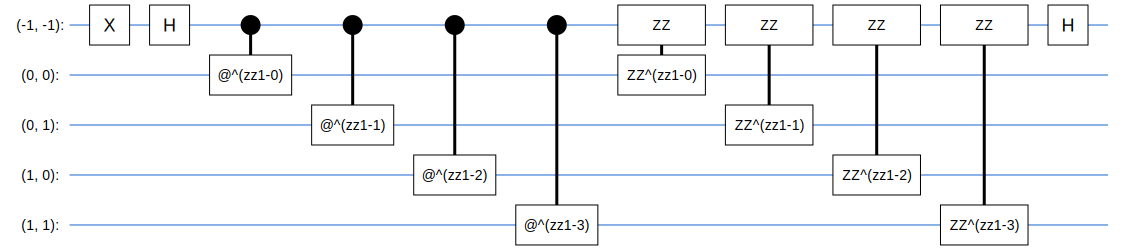

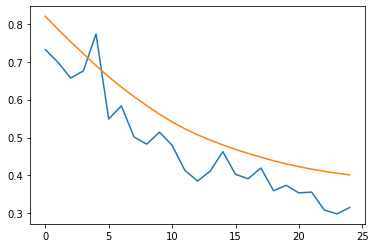

In [121]:
experiment = 7

print(experiment_log[experiment]['history'])
print(experiment_log[experiment]['gates'])

pyplot.plot(experiment_log[experiment]['history'].history['loss'])
pyplot.plot(experiment_log[experiment]['history'].history['val_loss'])

SVGCircuit(experiment_log[experiment]['circuit'])